In [3]:
# # Coarse Modeling (with Triple-Barrier + Meta) — VERBOSE EDITION
# - tb_meta uses daily PnL (zeros on non-event days) for Sharpe
# - GridSearch scoring: AUC for tb_meta, F1 for others (RMSE for regression)
# - Probabilities calibrated (isotonic) for tb_meta (no sample_weight through calibrator; see note)
# - p_star tuned on training slice with `best_threshold`
# - Binary classic leakage fixed (drops correct *_{window}D_{threshold} column)
# - Lots of progress logs, timings, and sanity guardrails

# %%
import sys, os, time, json, pickle, warnings
from datetime import datetime
import numpy as np
import pandas as pd

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression, f_classif
from sklearn.impute import SimpleImputer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

# Add parent directory to path to access custom modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.modelling_functions import (
    create_multi_class_target, create_target_variable,
    build_datasets_for_models, base_rule_ma_cross, meta_decision,
    calculate_sharpe_with_costs, best_threshold,
    purged_time_series_splits
)

# --- small logging helpers ---
def tstamp(): return time.strftime("%H:%M:%S")
def log(msg): print(f"[{tstamp()}] {msg}")
def secs(s):  return f"{s:,.2f}s"

In [ ]:
# --- 1) Load Data ---
DATA_PATH = r'C:\Users\epoch_bpjmdqk\Documents\Code\data\processed\financials__PGR.csv'
RESULTS_OUT = os.path.join(os.path.dirname(DATA_PATH), "coarse_model_results.csv")

try:
    data = pd.read_csv(DATA_PATH, index_col='Date', parse_dates=True)
    log(f"Data loaded: shape={data.shape}, from={data.index.min().date()} to={data.index.max().date()}")
except FileNotFoundError:
    raise FileNotFoundError(f"Data file not found: {DATA_PATH}")

# Config
target_ticker = 'PGR'
close = pd.to_numeric(data.get(f'Close_{target_ticker}'), errors='coerce').astype(float)
split_date = '2023-01-01' 


[17:55:57] Data loaded: shape=(6411, 1129), from=2000-03-08 to=2025-09-03


In [ ]:
# Boolean mask: True if column has any string values
str_cols_mask = data.apply(lambda col: col.map(lambda v: isinstance(v, str)).any())

# Column names with at least one string
str_cols = str_cols_mask[str_cols_mask].index.tolist()

print("Columns containing string values:")
print(str_cols)

# drop string columns
data = data.drop(columns=str_cols)

Columns containing string values:
['Regime_GIR_Label']


In [3]:
# --- 2. DEFINE THE EXPERIMENTS ---
# Define feature engineering configurations
feature_configs = {
    'baseline': None,
    # 'poly_2': {'name': 'PolynomialFeatures', 'params': {'degree': 2, 'include_bias': False}},
    'pca_3': {'name': 'PCA', 'params': {'n_components': 3}},
    'pruned_10': {'name': 'FeaturePruning', 'params': {'n_features_to_select': 10}}
}

# Define target configurations
target_configs = [
    {'type': 'binary', 'window': 5, 'threshold': 0.005},
    {'type': 'multi_class', 'window': 5, 'threshold': 0.01},
    {'type': 'multi_class_extreme', 'window': 5, 'threshold': 0.005, 'extreme_threshold': 0.02}, # Added new experiment
    {'type': 'regression', 'window': 5},
    {'type': 'tb_primary', 'H': 10, 'span_vol': 20, 'pt': 1.0, 'sl': 1.0},
    {'type': 'tb_meta',    'H': 10, 'span_vol': 20, 'pt': 1.0, 'sl': 1.0, 'p_star': 0.55},
]

# Define model configurations for classification and regression with coarse param grids
models_cls = [
    {'name': 'XGBoost', 'class': XGBClassifier, 'initial_params': {'eval_metric': 'logloss', 'random_state': 42}, 'param_grid': {'n_estimators': [50, 100], 'max_depth': [3, 5]}},
    {'name': 'CatBoost', 'class': CatBoostClassifier, 'initial_params': {'verbose': False, 'random_state': 42}, 'param_grid': {'n_estimators': [50, 100], 'depth': [3, 5]}},
    {'name': 'RandomForest', 'class': RandomForestClassifier, 'initial_params': {'random_state': 42, 'class_weight': 'balanced'}, 'param_grid': {'n_estimators': [50, 100], 'max_depth': [5, 10]}},
]

models_reg = [
    {'name': 'XGBoost', 'class': XGBRegressor, 'initial_params': {'objective': 'reg:squarederror', 'random_state': 42}, 'param_grid': {'n_estimators': [50, 100], 'max_depth': [3, 5]}},
    {'name': 'LinearRegression', 'class': LinearRegression, 'initial_params': {}, 'param_grid': {}}, # No params to tune for Linear Regression
]

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 1. Test Binary Target
binary_data = data.copy()
binary_data = create_target_variable(binary_data, target_ticker, window=5, threshold=0.005)
print('BINARY_TARGET_COLUMNS:', binary_data.columns.tolist())

# 2. Test Multi-Class Target
multi_class_data = data.copy()
multi_class_data = create_multi_class_target(multi_class_data, target_ticker, window=5, threshold=0.01, extreme_threshold=0.02)
print('MULTI_CLASS_TARGET_COLUMNS:', multi_class_data.columns.tolist())

# 3. Test Regression Target
regression_data = data.copy()
regression_data[f'{target_ticker}_target_return'] = regression_data[f'Close_{target_ticker}'].pct_change(periods=5).shift(5)
print('REGRESSION_TARGET_COLUMNS:', regression_data.columns.tolist())

BINARY_TARGET_COLUMNS: ['Open_JPM', 'High_JPM', 'Low_JPM', 'Close_JPM', 'Volume_JPM', 'Dividends_JPM', 'Stock Splits_JPM', 'Open_BAC', 'High_BAC', 'Low_BAC', 'Close_BAC', 'Volume_BAC', 'Dividends_BAC', 'Stock Splits_BAC', 'Open_WFC', 'High_WFC', 'Low_WFC', 'Close_WFC', 'Volume_WFC', 'Dividends_WFC', 'Stock Splits_WFC', 'Open_MS', 'High_MS', 'Low_MS', 'Close_MS', 'Volume_MS', 'Dividends_MS', 'Stock Splits_MS', 'Open_GS', 'High_GS', 'Low_GS', 'Close_GS', 'Volume_GS', 'Dividends_GS', 'Stock Splits_GS', 'Open_C', 'High_C', 'Low_C', 'Close_C', 'Volume_C', 'Dividends_C', 'Stock Splits_C', 'Open_BLK', 'High_BLK', 'Low_BLK', 'Close_BLK', 'Volume_BLK', 'Dividends_BLK', 'Stock Splits_BLK', 'Open_PGR', 'High_PGR', 'Low_PGR', 'Close_PGR', 'Volume_PGR', 'Dividends_PGR', 'Stock Splits_PGR', 'Open_AXP', 'High_AXP', 'Low_AXP', 'Close_AXP', 'Volume_AXP', 'Dividends_AXP', 'Stock Splits_AXP', 'Open_USB', 'High_USB', 'Low_USB', 'Close_USB', 'Volume_USB', 'Dividends_USB', 'Stock Splits_USB', 'Open_SCHW', '

In [ ]:
# --- 3) Experimental Loop ---
all_results = []
exp_start = time.time()

for t_idx, target_conf in enumerate(target_configs, 1):
    log(f"\n=== [{t_idx}/{len(target_configs)}] Target: {target_conf['type']} ===")
    data_target = data.copy()

    is_tb = target_conf['type'] in {'tb_primary', 'tb_meta'}
    eval_mode = 'classic'
    meta_side = None
    p_star_default = target_conf.get('p_star', 0.55)

    # ----- Classic targets -----
    if not is_tb:
        if target_conf['type'] == 'binary':
            data_target = create_target_variable(
                data_target, target_ticker,
                window=target_conf['window'], threshold=target_conf['threshold']
            )
            target_col = f'{target_ticker}_Target'
            model_list = models_cls

        elif 'multi_class' in target_conf['type']:
            extreme_threshold = target_conf.get('extreme_threshold', None)
            data_target = create_multi_class_target(
                data_target, target_ticker,
                window=target_conf['window'],
                threshold=target_conf['threshold'],
                extreme_threshold=extreme_threshold
            )
            target_col = f'{target_ticker}_Target_Multi'
            model_list = models_cls

        else:  # regression
            # forward return (lookahead)
            w = target_conf['window']
            ret_col = f'{target_ticker}_target_return'
            data_target[ret_col] = data_target[f'Close_{target_ticker}'].pct_change(periods=w).shift(-w)
            target_col = ret_col
            model_list = models_reg

        # Drop rows w/o target
        data_target = data_target.dropna(subset=[target_col])
        if data_target.empty:
            log("!! Skipping: no rows after target creation.")
            continue

        # Prepare X/y
        y_full = data_target[target_col]
        # Make sure the specific forward return column (source of target) is not a feature
        if target_conf['type'] == 'regression':
            leak_col = f'{target_ticker}_target_return'
        elif target_conf['type'] == 'binary':
            leak_col = f'{target_ticker}_target_return_{target_conf["window"]}D_{target_conf["threshold"]}'
        else:  # multi_class flavors
            leak_col = f'{target_ticker}_target_return_{target_conf["window"]}D'

        drop_feats = [f'Open_{target_ticker}', f'High_{target_ticker}',
                      f'Low_{target_ticker}', f'Close_{target_ticker}', leak_col, target_col]
        X_full = data_target.drop(columns=[c for c in drop_feats if c in data_target.columns], errors='ignore')

        # Chronological split
        X_train_full = X_full.loc[:split_date]
        y_train_full = y_full.loc[:split_date]
        X_test_full  = X_full.loc[split_date:]
        y_test_full  = y_full.loc[split_date:]

        # Verbose split stats
        def _cls_counts(y):
            vc = pd.Series(y).value_counts(normalize=False, dropna=False).to_dict()
            pr = pd.Series(y).value_counts(normalize=True, dropna=False).round(3).to_dict()
            return vc, pr

        log(f"Split @ {split_date} | Train n={len(X_train_full)} | Test n={len(X_test_full)}")
        if target_conf['type'] != 'regression':
            vc_tr, pr_tr = _cls_counts(y_train_full)
            vc_te, pr_te = _cls_counts(y_test_full)
            log(f"Train class counts={vc_tr} base-rates={pr_tr} | Test counts={vc_te} base-rates={pr_te}")

        # Encode labels for classic classification
        if target_conf['type'] in ['binary', 'multi_class', 'multi_class_extreme']:
            if len(pd.Series(y_train_full).unique()) < 2:
                log("!! Skipping: <2 classes in training.")
                continue
            le = LabelEncoder()
            y_train_full = le.fit_transform(y_train_full)
            y_test_full  = le.transform(y_test_full)

    # ----- Triple-barrier targets -----
    else:
        base_X = data_target.drop(columns=[f'Open_{target_ticker}', f'High_{target_ticker}',
                                           f'Low_{target_ticker}', f'Close_{target_ticker}'],
                                  errors='ignore')
        model_list = models_cls

        if target_conf['type'] == 'tb_primary':
            packs = build_datasets_for_models(
                X=base_X, close=close,
                span_vol=target_conf['span_vol'],
                H=target_conf['H'],
                pt_sl=(target_conf['pt'], target_conf['sl']),
                base_side=None
            )
            X_full = packs['primary_X']
            y_full = packs['primary_y'].map({-1: 0, 1: 1}).astype(int)
            weights_full = packs['primary_weights']
            t1_full = packs['primary_t1']
            eval_mode = 'tb_primary'
        else:
            base_side = base_rule_ma_cross(close, fast=10, slow=20)
            packs = build_datasets_for_models(
                X=base_X, close=close,
                span_vol=target_conf['span_vol'],
                H=target_conf['H'],
                pt_sl=(target_conf['pt'], target_conf['sl']),
                base_side=base_side
            )
            X_full = packs['meta_X']
            y_full = packs['meta_y']                # 0/1
            meta_side = packs['meta_side']          # +1/-1 per event
            weights_full = packs['meta_weights']
            t1_full = packs['meta_t1']
            eval_mode = 'tb_meta'

        # Chronological split by event timestamps
        X_train_full = X_full.loc[:split_date]
        y_train_full = y_full.loc[:split_date]
        X_test_full  = X_full.loc[split_date:]
        y_test_full  = y_full.loc[split_date:]
        log(f"Split @ {split_date} | Train events={len(X_train_full)} | Test events={len(X_test_full)}")
        if len(np.unique(y_train_full)) < 2:
            log("!! Skipping: <2 classes in training events.")
            continue

        # sample weights for train only (aligned)
        sample_weight = None
        if weights_full is not None:
            sw = weights_full.reindex(X_train_full.index)
            if sw is not None:
                sample_weight = sw.fillna(0).values
                log(f"Using sample_weight for train: nonzero={int(np.sum(sample_weight>0))}")

    # -------- Feature+Model loop (no leakage) --------
    for f_idx, (feat_name, feat_config) in enumerate(feature_configs.items(), 1):
        log(f"\n--- Features [{f_idx}/{len(feature_configs)}]: {feat_name} ---")

        # Clean infinities; imputation/scaling inside pipeline
        X_train_base = X_train_full.replace([np.inf, -np.inf], np.nan)
        X_test_base  = X_test_full.replace([np.inf, -np.inf], np.nan)

        for m_idx, model_conf in enumerate(model_list, 1):
            mname = model_conf['name']
            log(f"-> Model [{m_idx}/{len(model_list)}]: {mname}")
            t0 = time.time()

            model_initial_params = model_conf['initial_params'].copy()

            # scoring metric for the grid
            grid_scoring = (
                'neg_mean_squared_error' if (not is_tb and target_conf['type']=='regression')
                else ('roc_auc' if (is_tb and eval_mode=='tb_meta') else 'f1_macro')
            )

            # class imbalance handling (classic)
            per_fit_weights = None
            if not is_tb and target_conf['type'] in ['binary','multi_class','multi_class_extreme']:
                y_series = pd.Series(y_train_full)
                counts = y_series.value_counts().sort_index()
                total = counts.sum()
                class_weights = {cls: total / cnt for cls, cnt in counts.items()}
                if mname == 'XGBoost':
                    per_fit_weights = np.array([class_weights[y] for y in y_train_full])
                    model_initial_params['eval_metric'] = 'mlogloss'
                elif mname == 'CatBoost':
                    model_initial_params['class_weights'] = [class_weights[c] for c in sorted(class_weights.keys())]

            base_model = model_conf['class'](**model_initial_params)

            # ---- Pipeline (no leakage) ----
            steps = [('imputer', SimpleImputer(strategy='mean'))]
            if feat_name == 'pca_3':
                steps += [('scaler', StandardScaler()),
                          ('pca', PCA(**feature_configs['pca_3']['params']))]
            elif feat_name == 'pruned_10':
                score_func = f_regression if (not is_tb and target_conf['type']=='regression') else f_classif
                steps += [('selector', SelectKBest(score_func=score_func,
                                                   k=feature_configs['pruned_10']['params']['n_features_to_select']))]
            steps += [('model', base_model)]
            pipe = Pipeline(steps)

            # map param grid to pipeline
            param_grid = {f"model__{k}": v for k, v in model_conf['param_grid'].items()}

            # ---- CV objects ----
            if is_tb:
                t1_cv = t1_full.reindex(X_train_base.index)
                cv_obj = list(purged_time_series_splits(
                    X_train_base.index, t1_cv, n_splits=3, test_size=None, embargo=target_conf['H']
                ))
                log(f"Purged CV folds={len(cv_obj)} (embargo={target_conf['H']})")
            else:
                try:
                    cv_obj = TimeSeriesSplit(n_splits=3, gap=target_conf.get('window', 0))
                except TypeError:
                    cv_obj = TimeSeriesSplit(n_splits=3)
                log(f"TimeSeriesSplit folds=3 gap={target_conf.get('window', 0) if not is_tb else 0}")

            grid_search = GridSearchCV(
                estimator=pipe,
                param_grid=param_grid,
                scoring=grid_scoring,
                cv=cv_obj,
                n_jobs=-1,
                verbose=0
            )

            # weights routed to the last step inside the pipeline
            fit_kwargs = {}
            if is_tb and (sample_weight is not None):
                fit_kwargs['model__sample_weight'] = sample_weight
            elif (not is_tb) and (per_fit_weights is not None):
                fit_kwargs['model__sample_weight'] = per_fit_weights

            # Fit GS
            try:
                grid_search.fit(X_train_base, y_train_full, **fit_kwargs)
            except Exception as e:
                log(f"!! GridSearch failed: {type(e).__name__}: {e}")
                continue

            best_pipe = grid_search.best_estimator_
            log(f"Best CV score ({grid_scoring})={grid_search.best_score_:.4f} | params={grid_search.best_params_}")

            # -------- Evaluation --------
            try:
                if not is_tb:
                    y_pred = best_pipe.predict(X_test_base)
                    if target_conf['type'] == 'regression':
                        perf = float(np.sqrt(mean_squared_error(y_test_full, y_pred)))
                        log(f"Test RMSE={perf:.6f}")
                    else:
                        perf = float(f1_score(y_test_full, y_pred, average='macro', zero_division=0))
                        log(f"Test F1-macro={perf:.4f}")

                else:
                    if eval_mode == 'tb_primary':
                        y_pred = best_pipe.predict(X_test_base)
                        perf = float(f1_score(y_test_full, y_pred, average='macro', zero_division=0))
                        log(f"Test F1-macro (tb_primary)={perf:.4f}")

                    else:
                        # tb_meta: tune p* on train, compute daily Sharpe on test
                        if len(X_train_base) == 0 or len(X_test_base) == 0:
                            perf = float('nan')
                            log("!! Empty train/test window for tb_meta.")
                        else:
                            # --- Probability calibration ---
                            # NOTE: can't pass sample_weight cleanly via CalibratedClassifierCV on a Pipeline
                            # so we calibrate *without* weights and log that behavior.
                            calibrator = CalibratedClassifierCV(best_pipe, method='isotonic', cv=3)
                            log("Calibrating probabilities with isotonic (cv=3, no sample_weight through calibrator).")
                            calibrator.fit(X_train_base, y_train_full)

                            proba_train = calibrator.predict_proba(X_train_base)[:, 1]
                            side_train = meta_side.loc[X_train_base.index]
                            p_star_opt = best_threshold(proba_train, side_train, close, X_train_base.index) \
                                         or p_star_default
                            log(f"Chosen p*={p_star_opt:.3f} (default={p_star_default:.2f})")

                            proba_test = calibrator.predict_proba(X_test_base)[:, 1]
                            events_side_test = meta_side.loc[X_test_base.index]
                            signal_events = meta_decision(proba_test, side=events_side_test, p_star=p_star_opt)

                            if signal_events.empty:
                                perf = float('nan')
                                log("No meta signals generated on test.")
                            else:
                                test_start, test_end = signal_events.index.min(), signal_events.index.max()
                                test_days = close.loc[test_start:test_end].index
                                daily_signal = signal_events.reindex(test_days).fillna(0).astype(float)
                                daily_ret = close.pct_change().shift(-1).reindex(test_days).fillna(0)
                                strategy_returns = daily_signal * daily_ret
                                perf = float(calculate_sharpe_with_costs(strategy_returns, transaction_cost=0.001))
                                trades = int((signal_events != 0).sum())
                                exposure = float((daily_signal != 0).mean())
                                hit_rate = float(((strategy_returns > 0) & (daily_signal!=0)).sum() /
                                                 max(1, (daily_signal!=0).sum()))
                                log(f"Sharpe={perf:.3f} | trades={trades} | exposure={exposure:.2%} | hit={hit_rate:.2%}")

                all_results.append({
                    'Feature_Set': feat_name,
                    'Target_Type': target_conf['type'],
                    'Model': mname,
                    'Test_Performance': round(perf, 6),
                    'Best_Params': grid_search.best_params_,
                    'Train_Size': int(len(X_train_base)),
                    'Test_Size': int(len(X_test_base))
                })
                log(f"Done {mname} in {secs(time.time()-t0)}")

            except Exception as e:
                log(f"!! Evaluation failed for {mname}: {type(e).__name__}: {e}")


=== Target: binary ===

--- Experiment: Target=binary, Features=baseline ---
-> Model: XGBoost


ValueError: 
All the 12 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\epoch_bpjmdqk\Documents\Code\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\epoch_bpjmdqk\Documents\Code\venv\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\epoch_bpjmdqk\Documents\Code\venv\Lib\site-packages\sklearn\pipeline.py", line 655, in fit
    Xt = self._fit(X, y, routed_params, raw_params=params)
  File "c:\Users\epoch_bpjmdqk\Documents\Code\venv\Lib\site-packages\sklearn\pipeline.py", line 589, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ~~~~~~~~~~~~~~~~~~~~~~~~^
        cloned_transformer,
        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
        params=step_params,
        ^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\epoch_bpjmdqk\Documents\Code\venv\Lib\site-packages\joblib\memory.py", line 326, in __call__
    return self.func(*args, **kwargs)
           ~~~~~~~~~^^^^^^^^^^^^^^^^^
  File "c:\Users\epoch_bpjmdqk\Documents\Code\venv\Lib\site-packages\sklearn\pipeline.py", line 1540, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
  File "c:\Users\epoch_bpjmdqk\Documents\Code\venv\Lib\site-packages\sklearn\utils\_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "c:\Users\epoch_bpjmdqk\Documents\Code\venv\Lib\site-packages\sklearn\base.py", line 897, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ~~~~~~~~^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\epoch_bpjmdqk\Documents\Code\venv\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\epoch_bpjmdqk\Documents\Code\venv\Lib\site-packages\sklearn\impute\_base.py", line 436, in fit
    X = self._validate_input(X, in_fit=True)
  File "c:\Users\epoch_bpjmdqk\Documents\Code\venv\Lib\site-packages\sklearn\impute\_base.py", line 361, in _validate_input
    raise new_ve from None
ValueError: Cannot use mean strategy with non-numeric data:
could not convert string to float: 'Low Growth • Low Inflation • Risk-ON'


In [ ]:
# --- 4. Final Coarse Modeling Results Summary ---
elapsed = time.time() - exp_start
results_df = pd.DataFrame(all_results).sort_values(by='Test_Performance',
                                                   ascending=False if not results_df.empty else True)
log(f"\n--- Final Coarse Modeling Results Summary (total {len(results_df)} rows, {secs(elapsed)}) ---")
if results_df.empty:
    log("No successful results. Check logs above.")
else:
    print(results_df.to_string(index=False))

    # Save results
    try:
        results_df.to_csv(RESULTS_OUT, index=False)
        log(f"Saved results → {RESULTS_OUT}")
    except Exception as e:
        log(f"Warning: could not save results CSV: {e}")


--- Final Coarse Modeling Results Summary ---
Feature_Set         Target_Type            Model  Test_Performance                            Best_Params
   baseline             tb_meta          XGBoost            0.7336  {'max_depth': 5, 'n_estimators': 100}
  pruned_10             tb_meta          XGBoost            0.6792  {'max_depth': 3, 'n_estimators': 100}
   baseline             tb_meta         CatBoost            0.6393       {'depth': 5, 'n_estimators': 50}
      pca_3             tb_meta     RandomForest            0.5927   {'max_depth': 5, 'n_estimators': 50}
  pruned_10          tb_primary          XGBoost            0.4761   {'max_depth': 5, 'n_estimators': 50}
  pruned_10             tb_meta         CatBoost            0.4754       {'depth': 3, 'n_estimators': 50}
      pca_3              binary          XGBoost            0.4702  {'max_depth': 5, 'n_estimators': 100}
      pca_3          tb_primary     RandomForest            0.4641  {'max_depth': 10, 'n_estimators': 50}

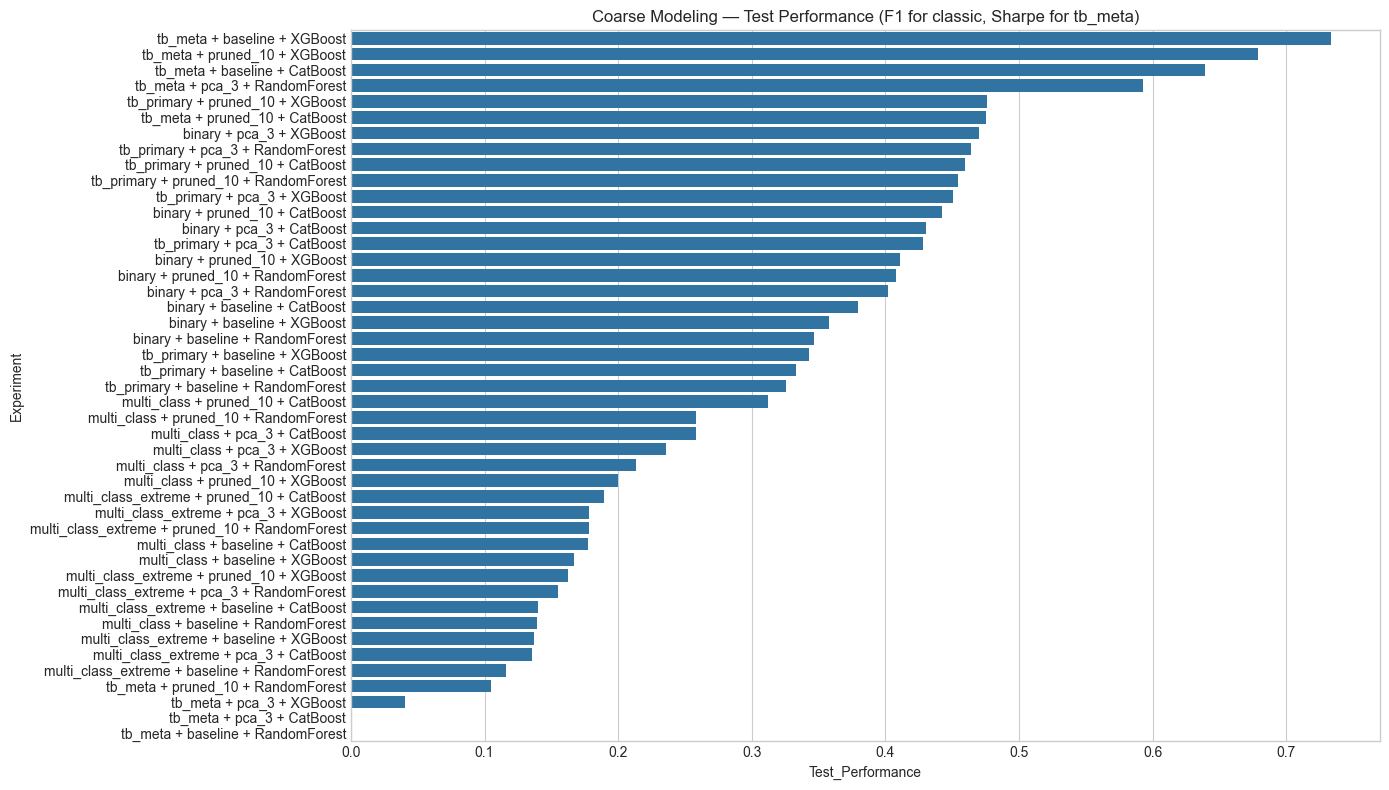

In [ ]:
# --- 5. Visualization (classification + tb_meta only) ---
try:
    if not results_df.empty:
        results_df['Experiment'] = results_df['Target_Type'] + ' + ' + results_df['Feature_Set'] + ' + ' + results_df['Model']
        cls_mask = ~results_df['Target_Type'].eq('regression')

        plt.style.use('seaborn-v0_8-whitegrid')
        plt.figure(figsize=(14,8))
        sns.barplot(x='Test_Performance', y='Experiment', data=results_df[cls_mask])
        plt.title('Coarse Modeling — Test Performance (F1 for classic, Sharpe for tb_meta)')
        plt.tight_layout()
        plt.show()
except Exception as e:
    log(f"Plotting skipped: {e}")